In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from keras import metrics
import random
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2
import PIL
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tqdm import tqdm
from keras import backend as K

In [5]:
def conv_block(input, num_filters):
    x = layers.Conv2D(num_filters, 3, padding="same")(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(num_filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs)
    return model

input_shape = (112, 112, 3)  # Adjust size and channels according to your dataset
model = build_unet(input_shape)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
optimizer1 = tf.keras.optimizers.Adam(learning_rate=0.15) 
# unet_model_retrain.compile(optimizer=optimizer1 ,
#                 #    loss=dice_loss,
#                    loss = 'binary_crossentropy',
#                    metrics=[metrics.Precision(),
#                             metrics.Recall(),
#                             metrics.FalsePositives(),
#                             metrics.FalseNegatives(),
#                             metrics.BinaryIoU(),
#                             'accuracy'])
model.compile(optimizer=optimizer1,
                   loss='binary_crossentropy',
                   metrics=[metrics.Precision(),
                            metrics.Recall(),
                            metrics.FalsePositives(),
                            metrics.FalseNegatives(),
                            metrics.BinaryIoU(),
                            'accuracy'])

In [6]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.model_selection import train_test_split
import cv2
import PIL
from PIL import Image
# Paths to your data.
images_path = './archive/crack_segmentation_dataset/train/images/'
masks_path = './archive/crack_segmentation_dataset/train/masks/'
img_size = (112, 112)

# Load and preprocess data
def load_data(images_path, masks_path, img_size):
    images = []  # List to store the images
    masks = []   # List to store the masks
    path = ''
    count = 0
    for filename in os.listdir(images_path):
        if count > 500:
            break
        img_path = images_path + filename
        mask_path = masks_path + filename  # Assuming mask has same filename
        # print(img_path)
        # Load and preprocess the image
        img = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        # print(img.size())
    #   if not img or not mask:
    #         continue
        img = cv2.resize(img, img_size) / 255.0

        # Load and preprocess the mask using OpenCV
        
        mask = cv2.resize(mask, img_size) / 255.0

        images.append(img)
        masks.append(mask)
        count += 1
    
    return np.array(images), np.array(masks)


In [7]:
# Load your data
images, masks = load_data(images_path, masks_path, (112, 112))


In [8]:
images.shape

(501, 112, 112, 3)

In [9]:
images1, masks1 = images[:500], masks[:500]

In [10]:
masks1 = np.expand_dims(masks1, axis=-1)

In [11]:
masks1.shape

(500, 112, 112, 1)

In [12]:

X_train, X_val, y_train, y_val = train_test_split(images1, masks1, test_size=0.2)
X_train = X_train.reshape((-1, 112, 112, 3))
X_val = X_val.reshape((-1, 112, 112, 3))
y_train = y_train.reshape((-1, 112, 112, 1))
y_val = y_val.reshape((-1, 112, 112, 1))
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)


X_train shape: (400, 112, 112, 3)
y_train shape: (400, 112, 112, 1)
X_val shape: (100, 112, 112, 3)
y_val shape: (100, 112, 112, 1)


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create data generators with desired augmentation parameters
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()  # No augmentation for validation data

# Generate batches of augmented data from arrays (X_train and y_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

# Train the model using the fit_generator function
history = model.fit(
    train_generator, 
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    epochs=10, 
    validation_data=val_generator,
    validation_steps=len(X_val) // 32  # Number of batches for validation
)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 121s 10s/step - accuracy: 0.9508 - binary_io_u_1: 0.4915 - false_negatives_1: 135227.6875 - false_positives_1: 0.0000e+00 - loss: 0.0962 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.9536 - val_binary_io_u_1: 0.4934 - val_false_negatives_1: 55906.0000 - val_false_positives_1: 0.0000e+00 - val_loss: 69.6263 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9380 - binary_io_u_1: 0.4884 - false_negatives_1: 24896.0000 - false_positives_1: 0.0000e+00 - loss: 0.0552 - precision_1: 0.0000e+00 - recall_1: 0.0000e+00 - val_accuracy: 0.8984 - val_binary_io_u_1: 0.4841 - val_false_negatives_1: 5099.0000 - val_false_positives_1: 0.0000e+00 - val_loss: 100.5954 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 116s 10s/step - accuracy: 0.9464 - binary_io_u_1: 0.4899 - false_negatives_1: 140005.6875 - false_positives_1: 0.00

KeyboardInterrupt: 

In [17]:
image_path = 'CFD_001.jpg'
input_image = cv2.imread(image_path)
cv2.imwrite( "test_input.jpg", input_image)
input_image = cv2.resize(input_image, (112, 112))/255.0  # Resize to match your model's input shape
# image = image / 255.0  # Normalize the pixel values

input_image = np.expand_dims(input_image, axis=0) 
# Convert the image to a NumPy array with the expected shape
# input_image = np.expand_dims(image, axis=0)  # Add a batch dimension
input_image.shape

(1, 112, 112, 3)

In [18]:
prediction = model.predict([input_image])
prediction.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


(1, 112, 112, 1)

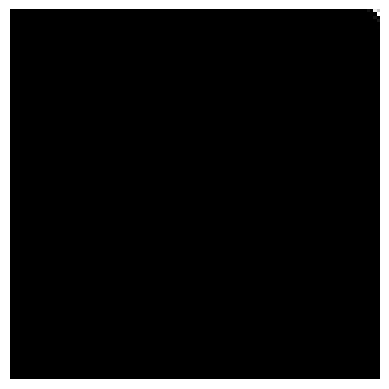

In [19]:
prediction_image = prediction[0]

# Now, display the image
plt.imshow(prediction_image, cmap='gray')  # Use an appropriate colormap if not binary
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()